### Code to compute the likelihood of a genealogy under a specific selection coefficient
#### (building on principles from moments, Stephens & Donnelly 2003 and importance sampling _a la_ CLUES, with the key equations coming from the transition probabilities in each generation)

Here, $T$ is the age of the allele in generations, $s$ is the selection coefficient and $n_0$ is the sample size in the present day. 

\begin{align*}
P\left(\mathcal{G} \mid n_0, s, T \right) &= P\left(i_T, i_{T-1}, \ldots, i_1, i_0, n_T, n_{T-1}, \ldots, n_1 \mid n_0, s, T \right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid n_T, \ldots \right) \times P\left(i_{T-1} \mid i_T,\ldots \right) \times \ldots \times P\left(i_0 \mid n_0, s, T\right) \times P\left(T\mid n_0, s\right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid n_T, \ldots \right) \times P\left(i_T \mid i_{T-1}, \ldots\right) \frac{P\left(i_{T-1}\mid n_{T-1}, \ldots\right)}{P\left(i_T \mid n_T,\ldots\right)} \times \ldots \times P\left(i_0 \mid n_0, s, T\right) \times P\left(T\mid n_0, s\right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid i_{T-1}, \ldots\right) \times \ldots \times P\left(i_0 \mid n_0, s, T\right)^2 \times P\left(T\mid n_0, s\right) 
\end{align*}

In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
import os
# method of moments framework + helper functions
from mom_functions import *
import newick
from newick import load
import readline
import tskit

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
## defunct now (not using the generation by generation formulation)
def calc_loglik_gen_xx(s, T, gendata, N):
    """
    Function to compute the likelihood of a genealogy under a specific selection coefficient and age of derived allele. 
    s : float, additive selection coefficient with h = 1/2
    T : int, age of derived allele in generations
    gendata : list of tuples, with # of elements indicating the height of the genealogy (in generations) & each tuple containing the # of derived lineages and total # of lineages in a specific generation (i, n), where i <= n (first element contains values from the present day)
    N : int, assuming constant population size (# of diploid inds)
    """

    pn, pi = 0, 0
    probarray = np.zeros(len(gendata))

    # going from the top to the bottom 
    for gen in range(1,len(gendata))[::-1]:
        # na = nb + 1
        if gendata[gen-1][1] > gendata[gen][1]:
            pn = 0.25*gendata[gen-1][1]*(gendata[gen-1][1]-1)/N
            # ia = ib + 1
            if gendata[gen-1][0] > gendata[gen][0]:
                pi = gendata[gen][0]/gendata[gen][1]
            # ia = ib
            else:
                pi = 1 - gendata[gen][0]/gendata[gen][1]
        # na = nb
        else: 
            pn = 1 - 0.25*gendata[gen-1][1]*(gendata[gen-1][1]-1)/N
            # ia = ib + 1
            if gendata[gen-1][0] > gendata[gen][0]:
                pi = s*gendata[gen][0]/gendata[gen][1]
            # ia = ib
            else:
                pi = 1 - s*gendata[gen][0]/gendata[gen][1]
        probarray[gen] = pn*pi
    
    fs = moments.Spectrum(np.array([0]+[1]+[0]*(gendata[0][1]-1)))
    # VS: check this scaled rate 
    fs.integrate([1], 0.5*T/N, gamma=2*N*s, theta=100)

    # VS: check the indexing on the returned SFAS object (reverse or correct)
    fsa = run_mom_iterate_constant(100, gendata[0][1], s, N, 100, {})

    probarray[0] = (fs[gendata[0][0]]/fs.sum())**2 * fsa[T,gendata[0][0]]/fsa[:,gendata[0][0]].sum()

    return sp.special.logsumexp(probarray) #-> returns the log-likelihood

In [3]:
# _projection_cache = {}
# def _cached_projection(proj_to, proj_from, hits, _projection_cache):
#     key = (proj_to, proj_from, hits)
#     # checking if this value has already been computed
#     try:
#         return _projection_cache[key]
#     except KeyError:
#         pass

#     proj_hits = np.arange(proj_to + 1) #proj_from - proj_to, hits - proj_hits
#     lncontrib =  sp.special.gammaln(proj_to + 1) - sp.special.gammaln(proj_hits + 1) - sp.special.gammaln(proj_to - proj_hits + 1) + sp.special.gammaln(proj_from - proj_to + 1) - sp.special.gammaln(hits - proj_hits) - sp.special.gammaln(proj_from - proj_to - hits + proj_hits + 1) - sp.special.gammaln(proj_from + 1) - sp.special.gammaln(hits + 1) + sp.special.gammaln(proj_from - hits + 1)

#     contrib = np.exp(lncontrib)

#     _projection_cache[key] = contrib
#     return contrib

# def _project_one_axis(fs, proj_to):
#     newfs = np.zeros(proj_to + 1)
#     proj_from = fs.sample_sizes[0]
#     for hits in range(1, proj_from):
#         least, most = max(proj_to - (proj_from - hits), 0), min(hits, proj_to)
#         proj = _cached_projection(proj_to, proj_from, hits, _projection_cache)
#         newfs[least:(most + 1)] +=  (fs[hits:(hits + 1)] * proj[least:(most + 1)])

#     return newfs

# %time _project_one_axis(fs, 302) ## --> wrong, but also slower
# %time fs.project([4])

#### How to extract true trees from mssel and convert to format readable by my code?

- Use the `-T` flag to output trees in Newick format in mssel
    - which tree to read in though? (units are in $4N_0$ gens)
- How to say which lineages are derived vs ancestral? 

In [2]:
## code from tsconvert (https://github.com/tskit-dev/tsconvert/blob/main/tsconvert/newick.py) to get tree-sequence from newick
def from_newick(
    string, *, min_edge_length=0, span=1, time_units=None, node_name_key=None
) -> tskit.TreeSequence:
    """
    Create a tree sequence representation of the specified newick string.

    The tree sequence will contain a single tree, as specified by the newick. All
    leaf nodes will be marked as samples (``tskit.NODE_IS_SAMPLE``). Newick names and
    comments will be written to the node metadata. This can be accessed using e.g.
    ``ts.node(0).metadata["name"]``.

    :param string string: Newick string
    :param float min_edge_length: Replace any edge length shorter than this value by this
        value. Unlike newick, tskit doesn't support zero or negative edge lengths, so
        setting this argument to a small value is necessary when importing trees with
        zero or negative lengths.
    :param float span: The span of the tree, and therefore the
        :attr:`~TreeSequence.sequence_length` of the returned tree sequence.
    :param str time_units: The value assigned to the :attr:`~TreeSequence.time_units`
        property of the resulting tree sequence. Default: ``None`` resulting in the
        time units taking the default of :attr:`tskit.TIME_UNITS_UNKNOWN`.
    :param str node_name_key: The metadata key used for the node names. If ``None``
        use the string ``"name"``, as in the example of accessing node metadata above.
        Default ``None``.
    :return: A tree sequence consisting of a single tree.
    """
    trees = newick.loads(string)
    if len(trees) > 1:
        raise ValueError("Only one tree can be imported from a newick string")
    if len(trees) == 0:
        raise ValueError("Newick string was empty")
    tree = trees[0]
    tables = tskit.TableCollection(span)
    if time_units is not None:
        tables.time_units = time_units
    if node_name_key is None:
        node_name_key = "name"
    nodes = tables.nodes
    nodes.metadata_schema = tskit.MetadataSchema(
        {
            "codec": "json",
            "type": "object",
            "properties": {
                node_name_key: {
                    "type": ["string"],
                    "description": "Name from newick file",
                },
                "comment": {
                    "type": ["string"],
                    "description": "Comment from newick file",
                },
            },
        }
    )

    id_map = {}

    def get_or_add_node(newick_node, time):
        if newick_node not in id_map:
            flags = tskit.NODE_IS_SAMPLE if len(newick_node.descendants) == 0 else 0
            metadata = {}
            if newick_node.name:
                metadata[node_name_key] = newick_node.name
            if newick_node.comment:
                metadata["comment"] = newick_node.comment
            id_map[newick_node] = tables.nodes.add_row(
                flags=flags, time=time, metadata=metadata
            )
        return id_map[newick_node]

    root = next(tree.walk())
    get_or_add_node(root, 0)
    for newick_node in tree.walk():
        node_id = id_map[newick_node]
        for child in newick_node.descendants:
            length = max(child.length, min_edge_length)
            if length <= 0:
                raise ValueError(
                    "tskit tree sequences cannot contain edges with lengths"
                    " <= 0. Set min_edge_length to force lengths to a"
                    " minimum size"
                )
            child_node_id = get_or_add_node(child, nodes[node_id].time - length)
            tables.edges.add_row(0, span, node_id, child_node_id)
    # Rewrite node times to fit the tskit convention of zero at the youngest leaf
    nodes = tables.nodes.copy()
    youngest = min(tables.nodes.time)
    tables.nodes.clear()
    for node in nodes:
        tables.nodes.append(node.replace(time=node.time - youngest + root.length))
    tables.sort()
    return tables.tree_sequence()

In [3]:
# tree = newick.read('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/haps5.0_r0.newick')
def read_mssel(msfile, nind):
    with open(msfile) as file:
        lines = [line.rstrip() for line in file]
    for i in range(len(lines)):
        if lines[i].split(':')[0]=='positions':
            pos = i
            break
        elif lines[i].split(' ')[0]=='segsites:':
            totsites = int(lines[i].split(' ')[1])
        elif lines[i].split(' ')[0]=='selsite:':
            selsite = int(lines[i].split(' ')[1])
    hapmat = np.zeros((nind,totsites),dtype='int')
    for i in range(hapmat.shape[0]):
        hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

    tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
    intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
    dersamp = np.where(hapmat[:,selsite])[0]+1; #ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
    samp = {} # -> only need to have one cos the other is the 1-this
    for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
        samp[tsktree.node(i).metadata['name']] = i 
    # getting internal node ids from derived samples
    derint = []
    for d in dersamp:
        u = samp[str(d)]
        path = []
        v = u
        while v != tskit.NULL:
            path.append(v)
            v = tsktree.first().parent(v)
        derint.extend(path[1:])
    derint = np.unique(derint)
    # creating an array of a list of events
    coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
    coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
    coaltimes[0,1] = -1
    for ii, itn in enumerate(intnodes):
        if itn in derint:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 1
        else:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 0
    haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
    haps[0,:] = [len(dersamp),tsktree.num_samples]
    for t in range(1,haps.shape[0]):
        if t in coaltimes[:,0]:
            if coaltimes[t==coaltimes[:,0],1]==0:
                haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
            else:
                haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
            if haps[t,0]<1:
                break
        else:
            haps[t,:] = haps[t-1,:]
    haps = haps[0:t,:]

    return haps, coaltimes

In [4]:
with open('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/haps-100.0_10.ms') as file:
    lines = [line.rstrip() for line in file]
for i in range(len(lines)):
    if lines[i].split(':')[0]=='positions':
        pos = i
        break
    elif lines[i].split(' ')[0]=='segsites:':
        totsites = int(lines[i].split(' ')[1])
    elif lines[i].split(' ')[0]=='selsite:':
        selsite = int(lines[i].split(' ')[1])
        tree = load(lines[i-1])[0]
hapmat = np.zeros((40,totsites),dtype='int')
for i in range(hapmat.shape[0]):
    hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

In [4]:
## need to constract an array of the coalescence events basically...
## can be done by investigating who the sample nodes are I guess...
tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
dersamp = np.where(hapmat[:,selsite])[0]+1; ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
samp = {} # -> only need to have one cos the other is 1-this
for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
    samp[tsktree.node(i).metadata['name']] = i 
# getting internal node ids from derived samples
derint = []
for d in dersamp:
    u = samp[str(d)]
    path = []
    v = u
    while v != tskit.NULL:
        path.append(v)
        v = tsktree.first().parent(v)
    derint.extend(path[1:])
derint = np.unique(derint)
# creating an array of a list of events
coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
coaltimes[0,1] = -1
for ii, itn in enumerate(intnodes):
    if itn in derint:
        coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
        coaltimes[ii+1,1] = 1
    else:
        coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
        coaltimes[ii+1,1] = 0
haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
haps[0,:] = [len(dersamp),tsktree.num_samples]
for t in range(1,haps.shape[0]):
    if t in coaltimes[:,0]:
        if coaltimes[t==coaltimes[:,0],1]==0:
            haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
        else:
            haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
        if haps[t,0]<1:
            break
    else:
        haps[t,:] = haps[t-1,:]
haps = haps[0:t,:]

plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=50$')

NameError: name 'lines' is not defined

### Code to empirically calculate the coalescent probabilities from simulations

In [5]:
# age = 600
# freqs = np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/Freq-220.0.txt')
# avgfreq = np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/allFreq-220.0.txt',delimiter=',').mean(axis=0)
allfreq220 = np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/allFreq-220.0.txt',delimiter=',')
# coals = np.zeros((1000,10))
# for i in range(1,coals.shape[0]+1):
#     for c in range(1,coals.shape[1]+1):
#         try:
#             hap = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-220.0_{:d}_c{:d}_t{:d}.ms'.format(int(i),int(c),int(age)),3)
#             coals[i-1,c-1] = np.max(np.where(hap[:,0]==2)[0])+2 # 1 for 0-indexing & 1 for going one gen back from the last gen that 2 derived alleles were observed
#         except: 
#             coals[i-1,c-1] = np.nan

# np.nanmean(sp.stats.binom.pmf(2,3,freqs)*np.nanmean(coals22,axis=1)) # -> mean coalescent time plateaus at 100 traj & 10 trees/traj

In [ ]:
# sp.stats.binom.pmf(2,3,avgfreq[-1])/np.sum(sp.stats.binom.pmf(range(1,3),3,avgfreq[-1]))
# fsa220proj3[-1,2]/np.sum(fsa220proj3[-1,1:-1])
plt.figure(dpi=200)
plt.plot(allfreq220[0:4,:])

In [855]:
# plt.hist(np.nanmean(coals,axis=1),bins=20,alpha=0.8,label='200'); plt.xlabel(r'observed coal. time'); plt.title(r'$a = 1850, n = 3$') 
# plt.hist(np.nanmean(coals22,axis=1),bins=10,alpha=0.6,label='20'); plt.legend(title=r'$\gamma$')
# plt.hist(np.nanmean(coals0,axis=1),bins=10,alpha=0.4,label='0'); 
# plt.hist(np.log10(np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/Freq-220.0.txt')),bins=10,label='200')
# plt.hist(np.log10(freqs),bins=20,label='20',alpha=0.6); plt.legend(title=r'$\gamma$'); plt.xlabel(r'$\log_{10}(freq)$')

# from statsmodels.distributions.empirical_distribution import ECDF 
# mask = np.where(~np.isnan(coals))
# coal_ecdf = ECDF(np.ravel(coals[mask]*sp.stats.binom.pmf(2,3,freqs[mask[0]]).reshape(-1,1)))
# plt.plot(range(1,1851),coal_ecdf(np.arange(1,1851)),color='#e76f51',linewidth=2,label='ECDF');

# fsa220 = run_mom_iterate_constant(age, 750, 220/10000, 10000, 200)[::-1]
# fsa220[fsa220<0] = 0
# fsa220proj3 = np.zeros((fsa220.shape[0],4)); #fsa220proj2 = np.zeros((fsa220.shape[0],3))
# for i in range(1,age):
#     fsa220proj3[i,:] = moments.Spectrum(fsa220[i,:]).project([3])
#     fsa220proj3[i,1:-1] = fsa220proj3[i,1:-1]/np.sum(fsa220proj3[i,1:-1])
# #     # fsa220proj2[i,:] = moments.Spectrum(fsa220[i,:]).project([2])
# #     # fsa220proj2[i,1:-1] = fsa220proj2[i,1:-1]/np.sum(fsa220proj2[i,1:-1])

# plt.figure(dpi=150)
# plt.plot(range(1,age),fsa220proj3[1:,1][::-1],color='deepskyblue',label='1/3'); plt.plot(range(1,age),fsa220proj3[1:,2][::-1],color='dodgerblue',label='2/3'); plt.xlabel(r'gens'); plt.ylabel(r'prob. value'); plt.grid(); plt.box(False); plt.xlabel('gens ago'); plt.plot(range(1,age+1),expXl[::-1],color='k',ls='--',alpha=0.8,linewidth=2,label=r'$\mathbb{E}[X(s)\mid i_t=2,n_t=3]$'); 
# plt.plot(range(1,age+1),allfreq.mean(axis=0)[::-1],color='r',ls='--',label='avg. freq. traj.'); plt.legend(); 
# plt.matshow(fsa220proj[:,1:2][::-1],aspect='auto',cmap='Blues',vmin=0.001); plt.colorbar(); plt.xlabel(r'sample allele freq $i/2$'); plt.ylabel('allele age (gens)'); plt.xticks([0],['1']); 
# plt.figure(dpi=150)
# plt.hist(bins[:-1],bins,weights=0.002*counts,alpha=0.7,color='grey')
# plt.plot(range(1,1850),fsa220proj2[1:,1],'#344e41',label=r'1/2'); plt.grid(); plt.box(False); plt.ylim((-0.01,1.01))
# plt.plot(range(1,1850),fsa220proj3[1:,1],color='deepskyblue',label='1/3'); plt.plot(range(1,1850),fsa220proj3[1:,2],color='dodgerblue',label='2/3'); plt.xlabel(r'gens'); plt.ylabel(r'prob. value'); plt.legend(loc='upper right'); 
# plt.plot(range(1,1851),coal_ecdf(np.arange(1,1851)),color='#e76f51',linewidth=2,label='ECDF'); 
# plt.plot(range(1,1850),1-fsa220proj2[1:1850,1]/fsa220proj3[1:1850,2]/20000,'--',color='#c1121f',label='expected',linewidth=2); 
# plt.plot(range(1,1851),prob,'--',color='#c1121f',label='expected',linewidth=2); 

(1000, 10)

In [928]:
# expXl = np.zeros(allfreq.shape[1]); kj = np.zeros(allfreq.shape[0])
# for t in range(allfreq.shape[1]):
#     for i in range(allfreq.shape[0]):
#         kj[i] = sp.stats.binom.pmf(range(1,3),3,allfreq[i,t]).sum()/sp.stats.binom.pmf(range(4),3,allfreq[i,t]).sum()
#     expXl[t] = np.sum(kj*allfreq[:,t]/np.sum(kj))
# plt.plot(expXl[::-1]); plt.plot(allfreq.mean(axis=0)[::-1])]

(0.40784313725490196, 0.40784313725490196, 0.40784313725490196, 1.0)

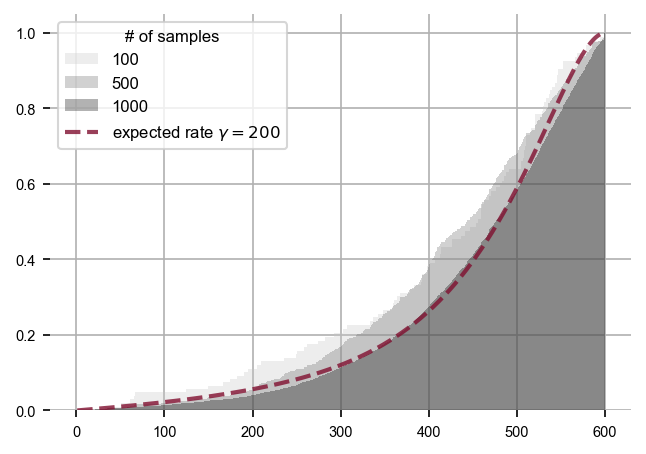

In [934]:
# show the change in histogram with 100, 200, 500 and 1000 samples...
plt.figure(dpi=150)
plt.hist(np.ravel(coals[:100,][mask[0][:100]]),cumulative=True,density=True,weights=np.repeat(sp.stats.binom.pmf(2,3,freqs[np.unique(mask[0])][:100]),10),bins=range(0,age+1,1),alpha=0.3,color=plt.get_cmap('Greys',4)(1),label='100'); plt.grid(); plt.box(False); 
plt.hist(np.ravel(coals[:500,][mask[0][:500]]),cumulative=True,density=True,weights=np.repeat(sp.stats.binom.pmf(2,3,freqs[np.unique(mask[0])][:500]),10),bins=range(0,age+1,1),alpha=0.3,color=plt.get_cmap('Greys',4)(2),label='500');
plt.hist(np.ravel(coals[mask]),cumulative=True,density=True,weights=np.repeat(sp.stats.binom.pmf(2,3,freqs[np.unique(mask[0])]),10),bins=range(0,age+1,1),alpha=0.3,color=plt.get_cmap('Greys',4)(3),label='1000');
plt.plot(range(1,age+1),prob,color='#800f2f',linewidth=2,ls='--',label=r'expected rate $\gamma=200$',alpha=0.8); plt.legend(title='# of samples',loc='upper left'); 

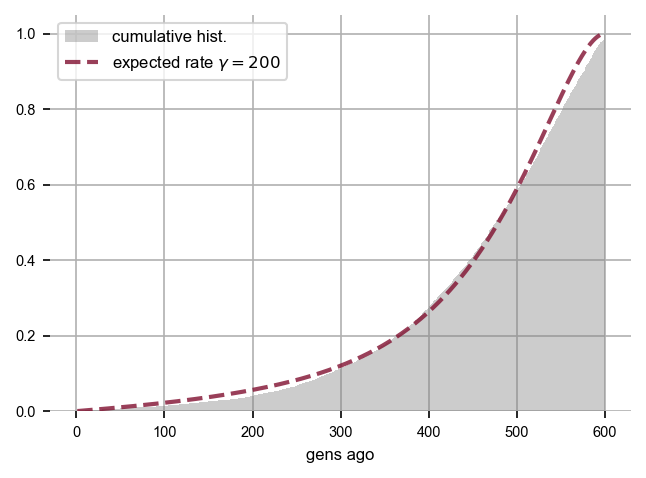

In [902]:
prob = calc_genexp_constant(age, np.log10(220/10000), 400, 10000)
# prob22 = calc_genexp_constant(1850, np.log10(22/20000), 250, 10000)
# probn22 = calc_genexp_constant(1850, np.log10(22/20000), 250, 10000)
# prob0 = calc_genexp_constant(1850, -6, 250, 10000)
# (counts, bins) = np.histogram(np.ravel(coals[mask]),weights=sp.stats.binom.pmf(2,3,freqs[mask[0]]),density=True,bins=range(0,,30))
# plt.hist(bins[:-1],bins,weights=counts,alpha=0.7,color='grey')
plt.figure(dpi=150)
plt.hist(np.ravel(coals[mask]),cumulative=True,density=True,weights=np.repeat(sp.stats.binom.pmf(2,3,freqs[np.unique(mask[0])]),10),bins=range(0,age+1,1),alpha=0.4,color='grey',label='cumulative hist.'); plt.grid(); plt.box(False); plt.xlabel('gens ago'); 
# plt.hist(np.ravel(coals[mask]),cumulative=True,density=True,bins=range(0,age+1,2),alpha=0.4,color='grey',label='cumulative hist.'); plt.grid(); plt.box(False); plt.xlabel('gens ago'); 
# plt.plot(range(1,1851),allfreq.mean(axis=0),color='#DE7C5A',linewidth=2,ls='--',label=r'$P(i=2\mid n=3, seg., X(t))$');  plt.legend()
plt.plot(range(1,age+1),prob,color='#800f2f',linewidth=2,ls='--',label=r'expected rate $\gamma=200$',alpha=0.8); plt.legend(loc='upper left'); #plt.plot(range(1,1851),fsa220proj3[:,2],color='#B10F2E',linewidth=2,ls='--')
# plt.plot(range(1,1851),prob22,color='#ff4d6d',linewidth=2,ls='--',label=r'expected, $\gamma=20$'); plt.plot(range(1,1851),probn22,color='#ff4d6d',linewidth=2,ls=':',label=r'expected, $\gamma=-20$'); plt.plot(range(1,1851),prob0,color='#ffb3c1',alpha=0.5,linewidth=2,ls='--',label=r'expected, $\gamma=0$'); 

In [901]:
def calc_genexp_constant(a, s, n, N):
    s = 10**s
    fsa = run_mom_iterate_constant(a+1, n, s, N, 400)
    fsa[fsa<0] = 0
    
    prob = np.zeros(a)
    rCA = np.zeros(a)

    # for t = 0: (present generation)
    fsprojn = moments.Spectrum(fsa[0,:]).project([3])
    fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()
    rCA[0] = 1/fsprojn[2]/N
    prob[0] = rCA[0]

    for t in range(1,a):
        ## compute coalescent rates 
        # fsprojn = moments.Spectrum(fsa[t-1,:]).project([3])
        fsprojn = moments.Spectrum(fsa[t,:]).project([3])
        fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

        ## basically want fsprojn[2] = avgfreq[-t]
        rCA[t] = 1/fsprojn[2]/N 
        # prob[t] = rCA[t]*np.prod(1-rCA[1:t])
        prob[t] = 1 - np.prod(1-rCA[:t])

    return prob
    # return -np.sum(np.log(prob))

In [33]:
def calc_genlik_constant2(s, n, N, haps):
    """Function that computes the likelihood but with the new formulation for computing ages 
    instead of running the SFAS framework for a large number A_max generations
    """
    s = 10**s
    # print(s)
    fsa = run_mom_iterate_constant(3*len(haps)+1, n, s, N, 400)
    fsa[fsa<0] = 0
    
    logprob = np.zeros(len(haps))
    rCa = np.zeros(len(haps)); rCA = np.zeros(len(haps))

    fsT = np.zeros(fsa.shape[0])

    for t in range(0,len(haps)-1):
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]

        ## compute coalescent rates 
        fsprojn = moments.Spectrum(fsa[t,:]).project([haps[t][1]]) # P_{t}(n_{t})
        fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

        fsprojntp1 = moments.Spectrum(fsa[t+1,:]).project([haps[t][1]-1]) # P_{t+1}(n_{t}-1)
        fsprojntp1[1:-1] = fsprojntp1[1:-1]/fsprojntp1[1:-1].sum()
        
        if haps[t][0] > 1:
            rCA[t] = haps[t][0]*(haps[t][0]-1)/2 * fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]] * 1/N 
            # rCA[t] = fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]]
        rCa[t] = (haps[t][1]-haps[t][0])*(haps[t][1]-haps[t][0]-1)/2 * fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] * 1/N
        # rCa[t] = fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] 

        if (haps[t,:] == haps[t+1,:]).all():
            logprob[t] = np.log(1 - rCA[t] - rCa[t]) ## -> this is close to 1, so can ignore this calculation and only do the step when it changes
        elif haps[t,0] == (haps[t+1,0] + 1):
            logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
        else:
            logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])
        # if haps[t,0] == (haps[t+1,0] + 1):
        #     logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
        # else:
        #     logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])

    fsf = moments.LinearSystem_1D.steady_state_1D(haps[0,1], gamma=s*N/2, theta=400)
    sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [3], 0.5, gamma=s*N/2, theta=400, dt_fac=1/N)
    age, _ = moments.Integration_nomig.calculate_page_condi(sfas, haps[0,0], [3], 0.5, gamma=s*N/2, theta=400, dt_fac=1/N)

    logprob[len(haps)-1] = np.log(age[len(haps)]/np.sum(age))

    return [rCa[:-1], rCA[:-1], logprob]
    # return -np.nansum(logprob[:-1])

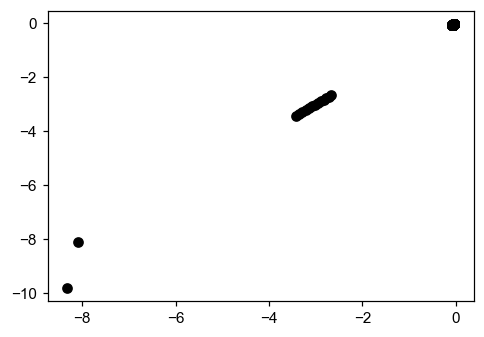

In [31]:
# foo = lambda s: calc_genlik_constant(s, 100, 10000, haps) 
# -np.sum(foo(-3.5)[2])
# foo2 = lambda s: calc_genlik_constant2(s, 100, 10000, haps) 
# -np.sum(foo2(-3.5)[2])
plt.plot(foo(-3)[2], foo2(-3)[2], 'ko')

# N = 10000
# fsf = moments.LinearSystem_1D.steady_state_1D(haps[0,1], gamma=0.5, theta=200)
# sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [2], 10, gamma=0.5, theta=200, dt_fac=1/(N-1))
# age, _ = moments.Integration_nomig.calculate_page_condi(sfas, haps[0,0], [2], 10, gamma=0.5, theta=200, dt_fac=1/(N-1))
# plt.plot(age); plt.title(np.sum(age))
# fsa = run_mom_iterate_constant(50*len(haps)+1, haps[0,1], 1/10000, N, 400)
# age[len(haps)]/np.sum(age), fsa[-len(haps),3]/np.sum(fsa[:,3]),

In [12]:
def calc_genlik_constant(s, n, N, haps):
    s = 10**s
    # print(s)
    # using the old formulation
    fsa = run_mom_iterate_constant(10*len(haps)+1, n, s, N, 400)
    fsa[fsa<0] = 0

    logprob = np.zeros(len(haps))
    rCa = np.zeros(len(haps)); rCA = np.zeros(len(haps))

    fsT = np.zeros(fsa.shape[0])

    for t in range(0,len(haps)-1):
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]
        # fsT[t] = project(fsa[t,:], n, haps[0][1])[haps[0][0]]

        ## compute coalescent rates 
        fsprojn = moments.Spectrum(fsa[t,:]).project([haps[t][1]]) # P_{t}(n_{t})
        # fsprojn = project(fsa[t,:], n, haps[t][1]) 
        fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

        fsprojntp1 = moments.Spectrum(fsa[t+1,:]).project([haps[t][1]-1]) # P_{t+1}(n_{t}-1)
        # fsprojntp1 = project(fsa[t+1,:], n, haps[t][1]-1)
        fsprojntp1[1:-1] = fsprojntp1[1:-1]/fsprojntp1[1:-1].sum()
        
        if haps[t][0] > 1:
            rCA[t] = haps[t][0]*(haps[t][0]-1)/2 * fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]] * 1/N 
            # rCA[t] = fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]]
        rCa[t] = (haps[t][1]-haps[t][0])*(haps[t][1]-haps[t][0]-1)/2 * fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] * 1/N
        # rCa[t] = fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] 

        if (haps[t,:] == haps[t+1,:]).all():
            logprob[t] = np.log(1 - rCA[t] - rCa[t]) ## -> this is close to 1, so can ignore this calculation and only do the step when it changes
        elif haps[t,0] == (haps[t+1,0] + 1):
            logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
        else:
            logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])

    for t in range(len(haps),10*len(haps)):
        # print(t,end=',')
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]
        # fsT[t] = project(fsa[t,:], n, haps[0][1])[haps[0][0]]

    logprob[len(haps)-1] = np.log(fsT[-len(haps)]/fsT.sum())

    return [rCa[:-1], rCA[:-1], logprob]
    # return -np.nansum(logprob[:-1])

In [527]:
def calc_genlik_constant_brlen(s, n, N, haps, brlen):
    s = 10**s
    # print(s)
    if brlen[1] < brlen[0]:
        brlen = brlen[::-1]
        
    fsabig = run_mom_iterate_constant(20*len(haps)+1, n, s, N, 400) 
    fsabig[fsabig<0] = 0

    logprobt = np.zeros(int(brlen[1]-brlen[0]+2))

    ## takes about 12s for 20 gens with 2n=100
    for T in range(brlen[0],brlen[1]+1):
        print(T,end=', ')
        fsa = run_mom_iterate_constant(T+1, n, s, N, 400) 
        fsa[fsa<0] = 0

        logprob = np.zeros(T)
        rCa = np.zeros(T); rCA = np.zeros(T)

        fsT = np.zeros(fsa.shape[0])

        for t in range(0,T-1):
            fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]
            ## compute coalescent rates 
            fsprojn = moments.Spectrum(fsa[t,:]).project([haps[t][1]]) # P_{t}(n_{t})
            fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

            fsprojntp1 = moments.Spectrum(fsa[t+1,:]).project([haps[t][1]-1]) # P_{t+1}(n_{t}-1)
            fsprojntp1[1:-1] = fsprojntp1[1:-1]/fsprojntp1[1:-1].sum()
            
            if haps[t][0] > 1:
                rCA[t] = haps[t][0]*(haps[t][0]-1)/2 * fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]] * 1/N 
                # rCA[t] = fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]]
            rCa[t] = (haps[t][1]-haps[t][0])*(haps[t][1]-haps[t][0]-1)/2 * fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] * 1/N
            # rCa[t] = fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] 

            if (haps[t,:] == haps[t+1,:]).all():
                logprob[t] = np.log(1 - rCA[t] - rCa[t])
            elif haps[t,0] == (haps[t+1,0] + 1):
                logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
            else:
                logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])

        logprobt[T-brlen[0]] = np.sum(logprob)

    plt.plot(range(brlen[0],brlen[1]+1), -logprobt[:-1], '-bo'); plt.xlabel('age of mutation'); #plt.ylabel(r'$\ell$')   
     
    fsT = np.zeros(fsabig.shape[0])
    for t in range(1,fsabig.shape[0]):
        fsT[t] = moments.Spectrum(fsabig[t,:]).project([haps[0][1]])[haps[0][0]]

    ## P(T | {T_l, T_u}) x P({T_l, T_u} | s)
    ## takes about 10s for 20 generations with 2n=100 
    print(np.log(fsT[-brlen[1]:-brlen[0]].sum()/fsT.sum()))
    logprobt[-1] += np.log(1/(brlen[1]-brlen[0])) + np.log(fsT[-brlen[1]:-brlen[0]].sum()/fsT.sum())

    return logprobt
    # return -np.nansum(logprob[:-1])

In [150]:
def calc_genlik_changing(s, n, N, haps):
    s = 10**s
    # print(s)
    t0 = time.time()
    fsa = run_mom_iterate_changing5(n, s, N, 400)
    fsa[fsa<0] = 0
    t1 = time.time()
    print(t1-t0)

    t0 = time.time()
    logprob = np.zeros(len(haps))
    rCa = np.zeros(len(haps)); rCA = np.zeros(len(haps))

    fsT = np.zeros(fsa.shape[0])

    for t in range(0,len(haps)-1):
        # print(t)
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]
        ## compute coalescent rates 
        fsprojn = moments.Spectrum(fsa[t,:]).project([haps[t][1]]) # P_{t}(n_{t})
        fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

        fsprojntp1 = moments.Spectrum(fsa[t+1,:]).project([haps[t][1]-1]) # P_{t+1}(n_{t}-1)
        fsprojntp1[1:-1] = fsprojntp1[1:-1]/fsprojntp1[1:-1].sum()
        
        if haps[t][0] > 1:
            rCA[t] = haps[t][0]*(haps[t][0]-1)/2 * fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]] * 1/N[t] 
            # rCA[t] = fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]]
        rCa[t] = (haps[t][1]-haps[t][0])*(haps[t][1]-haps[t][0]-1)/2 * fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] * 1/N[t]
        # rCa[t] = fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] 

        if (haps[t,:] == haps[t+1,:]).all():
            logprob[t] = np.log(1 - rCA[t] - rCa[t])
        elif haps[t,0] == (haps[t+1,0] + 1):
            logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
        else:
            logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])
    t1 = time.time()
    print(t1-t0)

    t0 = time.time()
    for t in range(len(haps),len(N)-1):
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]

    logprob[len(haps)-1] = np.log(fsT[-len(haps)]/fsT.sum())
    t1 = time.time()
    print(t1-t0)

    # demonew[0,1] = len(haps)
    # t0 = time.time()
    # fsf = moments.LinearSystem_1D.steady_state_1D(haps[0,1], gamma=s*N[-1], theta=400)
    # sfas2 = {}
    # sfas2[0] = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1], demonew[0,1]/demonew[0,0], gamma=s*N[-1], dt_fac=1/demonew[0,1], theta=400)
    # for ep in range(1,len(demonew)):
    #     sfas2[ep] = moments.Integration_nomig.integrate_nomig_viv(sfas2[ep-1][-1], [demonew[ep,0]/demonew[0,0]], demonew[ep,1]/demonew[ep,0], gamma=N[-1]*s, dt_fac=1/demonew[ep,1], theta=200)
    # age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[len(demonew)-1], haps[0,0], [demonew[len(demonew)-1,0]/demonew[0,0]], demonew[len(demonew)-1,1]/demonew[0,0], gamma=N[-1]*s, dt_fac=1/(demonew[len(demonew)-1,1]-1), theta=200)
    # for e in range(0,ep)[::-1]:
    #     age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[e], age, [demonew[e,0]/demonew[0,0]], demonew[e,1]/demonew[0,0], gamma=N[-1]*s, dt_fac=1/(demonew[e,1]-1), theta=400, X1=X1)

    # logprob[len(haps)-1] = np.log(age[len(haps)-1]/np.sum(age))
    # t1 = time.time()
    # print(t1-t0)

    return [rCa[:-1], rCA[:-1], logprob]

In [121]:
# np.cumsum(demo[::-1][:,1]), demo[::-1][:,1]
# fsf = moments.LinearSystem_1D.steady_state_1D(haps[0,1], gamma=s*N, theta=400)
# sfas2 = {}
# sfas2[0] = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1], demonew[0,1]/demonew[0,0], gamma=s*N, dt_fac=1/demonew[0,1], theta=400)
# for ep in range(1,len(demonew)):
#     sfas2[ep] = moments.Integration_nomig.integrate_nomig_viv(sfas2[ep-1][-1], [demonew[ep,0]/demonew[0,0]], demonew[ep,1]/demonew[ep,0], gamma=N*s, dt_fac=1/demonew[ep,1], theta=200)
# age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[len(demonew)-1], haps[0,0], [demonew[len(demonew)-1,0]/demonew[0,0]], demonew[len(demonew)-1,1]/demonew[0,0], gamma=N*s, dt_fac=1/(demonew[len(demonew)-1,1]-1), theta=200)
# for e in range(0,ep)[::-1]:
#     age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[e], age, [demonew[e,0]/demonew[0,0]], demonew[e,1]/demonew[0,0], gamma=N*s, dt_fac=1/(demonew[e,1]-1), theta=400, X1=X1)
# plt.plot(age/np.sum(age))

array([[ 28948,    200],
       [ 32326,     10],
       [ 38110,     10],
       [ 44932,     10],
       [ 52972,     10],
       [ 62452,     10],
       [ 73630,     10],
       [ 86806,     10],
       [102342,     10],
       [120658,     10],
       [142250,     10],
       [167708,     10],
       [197722,     10],
       [233108,     10],
       [274826,     10],
       [324010,     10],
       [381998,     10],
       [450362,     10],
       [530962,     10],
       [625984,     10],
       [738014,     10],
       [834302,      5]])

In [239]:
def calc_genlik_changing_coal(s, n, coalfile, haps):
    s = 10**s
    # print(s)

    # creating an N vector using the coalescent rates from Relate
    coal = pd.read_csv(coalfile)
    epochs = np.array(coal.iloc[0,0].split(' ')[:-1],dtype='float')
    Neff = 0.5/np.array(coal.iloc[1,0].split(' ')[2:-1],dtype='float') # -> from Relate documentation

    ## check this code by plotting it again
    N = np.zeros(len(haps))
    N[:int(epochs[1])] = Neff[0]
    for ep in range(1,np.max(np.where(epochs<3000))):
        N[int(epochs[ep]):int(epochs[ep+1])] = Neff[ep-1]
    # N[int(epochs[np.max(np.where(epochs<len(haps)))]):len(haps)] = Neff[ep]
    N = N[::-1]

    fsa = run_mom_iterate_changing5(n, s, N, 400)
    fsa[fsa<0] = 0

    logprob = np.zeros(len(haps))
    rCa = np.zeros(len(haps)); rCA = np.zeros(len(haps))

    fsT = np.zeros(fsa.shape[0])

    for t in range(0,len(haps)-1):
        # print(t)
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]
        ## compute coalescent rates 
        fsprojn = moments.Spectrum(fsa[t,:]).project([haps[t][1]]) # P_{t}(n_{t})
        fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()

        fsprojntp1 = moments.Spectrum(fsa[t+1,:]).project([haps[t][1]-1]) # P_{t+1}(n_{t}-1)
        fsprojntp1[1:-1] = fsprojntp1[1:-1]/fsprojntp1[1:-1].sum()
        
        if haps[t][0] > 1:
            rCA[t] = haps[t][0]*(haps[t][0]-1)/2 * fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]] * 1/N[t] 
            # rCA[t] = fsprojntp1[haps[t][0]-1]/fsprojn[haps[t][0]]
        rCa[t] = (haps[t][1]-haps[t][0])*(haps[t][1]-haps[t][0]-1)/2 * fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] * 1/N[t]
        # rCa[t] = fsprojntp1[haps[t][1]-haps[t][0]-1]/fsprojn[haps[t][1]-haps[t][0]] 

        if (haps[t,:] == haps[t+1,:]).all():
            logprob[t] = np.log(1 - rCA[t] - rCa[t])
        elif haps[t,0] == (haps[t+1,0] + 1):
            logprob[t] = np.log(rCA[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCA[t]) -> both quantities are the same since rCa/A<<1
        else:
            logprob[t] = np.log(rCa[t]) #sp.stats.expon.logpdf(1,loc=0,scale=1/rCa[t])

    for t in range(len(haps),len(N)-1):
        fsT[t] = moments.Spectrum(fsa[t,:]).project([haps[0][1]])[haps[0][0]]

    logprob[len(haps)-1] = np.log(fsT[-len(haps)]/fsT.sum())

    return [rCa[:-1], rCA[:-1], logprob]

In [11]:
## speeding up the project code using simple funcs
from scipy.special import gammaln ## gammaln(N + 1) - gammaln(k + 1) - gammaln(N - k + 1)
lncomb = lambda N, k: gammaln(N + 1) - gammaln(k + 1) - gammaln(N - k + 1)
projection_cache = {}
def project(data, proj_from, proj_to):
    out = np.zeros(proj_to+1)
    # saves very little time ignoring the small entries using np.where(data>1e-8)[0]
    for hits in range(proj_from + 1): 
        from_slice = slice(hits,hits+1)
        least, most = max(proj_to - (proj_from - hits), 0), min(hits, proj_to)
        # print(least, most)
        to_slice = slice(least, most + 1)
        proj_hits = np.arange(proj_to + 1)
        try: 
            proj = projection_cache[(proj_to, proj_from, hits)]
        except KeyError:
            lncontrib = lncomb(proj_to, proj_hits)
            lncontrib += lncomb(proj_from - proj_to, hits - proj_hits)
            lncontrib -= lncomb(proj_from, hits)
            proj = np.exp(lncontrib)
            projection_cache[(proj_to, proj_from, hits)] = np.exp(lncontrib)        
        proj_slice = slice(least, most + 1)
        out[to_slice] += data[from_slice] * proj[proj_slice]
    return out

CPU times: user 6.45 ms, sys: 1.18 ms, total: 7.62 ms
Wall time: 6.93 ms


[]

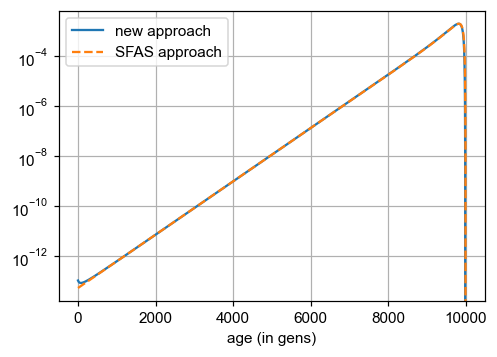

In [175]:
# %time fsf = moments.LinearSystem_1D.steady_state_1D(600, gamma=50, theta=400)
# fsf = moments.Spectrum(fsf)
# fsf.integrate([1], 0.1, gamma=50, dt_fac=0.0005, theta=400)
# %time moments.Integration_nomig.integrate_nomig(fsf.data, [1], 0.1, gamma=50, theta=400, dt_fac=1e-4)
# fsf = fsf.project([100])
# moments.Plotting.plot_1d_fs(fsf)
# %time sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1], 1, gamma=50, theta=400, dt_fac=1.001e-4)
# plt.plot(sfas[0][1:-1], sfas[100][1:-1], 'ko');  plt.axline((10,10),slope=1); plt.loglog();

# %time fsf = moments.LinearSystem_1D.steady_state_1D(500, gamma=25, theta=400)
# sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1], 1, gamma=25, theta=400, dt_fac=1.001e-4)
# age, _ = moments.Integration_nomig.calculate_page_condi(sfas, 5, [1], 1, gamma=25, theta=400, dt_fac=1.001e-4)
# %time fsa = run_mom_iterate_constant(10000, 500, 25/5000, 5000, 400)[::-1]

%time fsf = moments.LinearSystem_1D.steady_state_1D(500, gamma=25, theta=400)
sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [2], 1, gamma=25, theta=400, dt_fac=1.001e-4)
age, _ = moments.Integration_nomig.calculate_page_condi(sfas, 5, [2], 1, gamma=25, theta=400, dt_fac=1.001e-4)
fsa = run_mom_iterate_constant(10000, 500, 50/10000, 10000, 400)[::-1]

plt.plot(age[::-1]/np.sum(age),label='new approach'); plt.plot(fsa[:,5][::-1]/fsa[:,5].sum(),ls='--',label='SFAS approach'); plt.xlabel('age (in gens)'); plt.grid(); plt.legend(); plt.semilogy() 

In [47]:
# sfas = np.append(sfas,moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1.], .25, gamma=5, dt_fac=1.001e-3, theta=400), axis=0)
# age.shape, sfas.shape
# age2.shape, sfas2.shape, age.shape, sfas.shape
# plt.plot(np.append(age,age2)/np.sum(np.append(age,age2)))
# age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[::-1], 50, [4.], .5, gamma=5, dt_fac=2.001e-3, theta=200)
# plt.plot(age[1:-1]); plt.plot(X1[1:-1]); #plt.semilogy()
# plt.imshow(np.log10(sfas[:,1:-1]),cmap='OrRd',aspect='auto'); plt.colorbar()

-1.0999900009997824e-07

In [116]:
# df1 = pd.DataFrame()
# for i in range(1,11):
#     df = pd.read_csv("PReFerSims/outfiles/Expansion10.{}.full_out.txt".format(i),sep='\t',header=None,names=['','Xl','s','al','id'])
#     # df = pd.read_csv("PReFerSims/outfiles/ConstantSize0.0_n400_sim{}.3.full_out.txt".format(i),sep='\t',header=None,names=['','Xl','s','al','id'])
#     df['sXl'] = df['Xl']*500 #rng.binomial(n=n, p=df1['Xl'])
#     df['al'] = len(Nc)+1 - df['al']
#     df1 = pd.concat([df1,df])

750

CPU times: user 6.08 ms, sys: 1.2 ms, total: 7.28 ms
Wall time: 6.61 ms
CPU times: user 83.4 ms, sys: 2.11 ms, total: 85.5 ms
Wall time: 85.4 ms
CPU times: user 26.1 ms, sys: 967 µs, total: 27 ms
Wall time: 26.9 ms
CPU times: user 25.5 ms, sys: 881 µs, total: 26.4 ms
Wall time: 26.2 ms
CPU times: user 84.7 ms, sys: 1.54 ms, total: 86.2 ms
Wall time: 86.1 ms


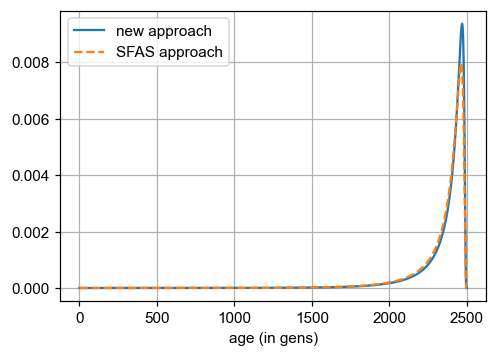

In [79]:
# Nc = np.concatenate((np.repeat(2000,500),np.repeat(1000,2000)))
# plt.plot(Nc); plt.xlabel('gens ago'); plt.ylabel('pop. size (N)')
%time fsf = moments.LinearSystem_1D.steady_state_1D(500, gamma=5, theta=400)
%time sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1.], 2, gamma=5, dt_fac=.5001e-3, theta=400)
%time sfas2 = moments.Integration_nomig.integrate_nomig_viv(sfas[-1], [2.], 0.5, gamma=5, dt_fac=2.001e-3, theta=200)
%time age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2, 10, [2.], 0.5, gamma=5, dt_fac=2.001e-3, theta=200)
%time age, _ = moments.Integration_nomig.calculate_page_condi(sfas, age, [1.], 2., gamma=5, dt_fac=.5001e-3, theta=400, X1=X1)

## TODO build the likelihood model into this framework and see how fast it is compared to CLUES/CLUES2

# %time fsa2 = run_mom_iterate_changing5(500, 10/1000, Nc[::-1], 400)
# plt.imshow(np.log10(fsa2), cmap='OrRd', aspect='auto', vmin=-6); plt.colorbar()

plt.plot(age[::-1]/np.sum(age),label='new approach'); plt.plot(fsa2[::-1][:,10]/fsa2[:,10].sum(),ls='--',label='SFAS approach'); plt.grid(); plt.legend(); plt.xlabel(r'age (in gens)'); #plt.semilogy()

KstestResult(statistic=0.06540241233718047, pvalue=1.752982009794758e-05)


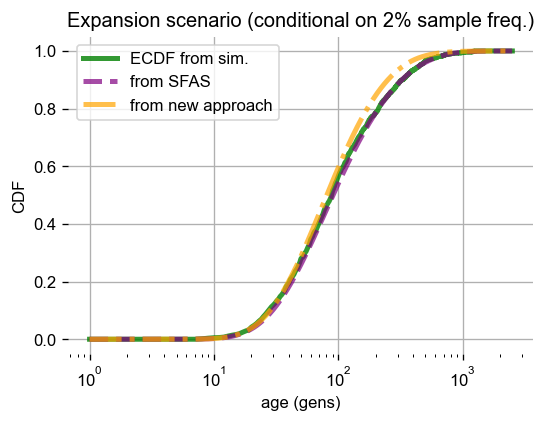

In [805]:
# from statsmodels.distributions.empirical_distribution import ECDF
# age_ecdf = ECDF(df1['al'][df1['sXl']==10])
totage = np.sum(age); cumsumage = [np.sum(age[:a])/totage for a in np.arange(1,2501)]
pk = [age[a]/totage for a in np.arange(1,2500-1)]
cstm = sp.stats.rv_discrete(name='cstm', values=(np.arange(1,2500-1),pk/np.sum(pk)))
print(sp.stats.kstest(df1['al'][df1['sXl']==10].values,cstm.cdf)) 
# totage2 = fsa2[:,10].sum(); cumsumage2 = [fsa2[:a,10].sum()/totage2 for a in np.arange(1,2501)]
# pk2 = [fsa2[a,10].sum()/totage2 for a in np.arange(1,2500-1)]
# cstm2 = sp.stats.rv_discrete(name='cstm', values=(np.arange(1,2500-1),pk2/np.sum(pk2)))
# print(sp.stats.kstest(df1['al'][df1['sXl']==10].values,cstm2.cdf)) 
plt.figure(dpi=120)
plt.plot(np.arange(1,2501),age_ecdf(np.arange(1,2501)),color='green',alpha=0.8,linewidth=3,label='ECDF from sim.'); plt.semilogx(); plt.xlabel('age (gens)'); plt.title(r'Expansion scenario (conditional on 2% sample freq.)'); plt.ylabel('CDF'); plt.grid(); plt.box(False); plt.plot(np.arange(1,2501),cumsumage2,color='purple',alpha=0.7,linewidth=3,ls='--',label=r'from SFAS'); plt.plot(np.arange(1,2501),cumsumage,color='orange',alpha=0.7,linewidth=3,ls='-.',label=r'from new approach'); plt.legend()

In [151]:
# J = calcJK13(100)
# S = 0.5 * 0.001 * calcS(100+1, J)
# D = 0.25/Nc[0] * calcD(100+1)
# slv = linalg.factorized(sp.sparse.identity(S.shape[0], dtype="float", format="csc") - 0.5 * (D + S))
# Q = sp.sparse.identity(S.shape[0], dtype="float", format="csc") + 0.5 * (D + S)
# slv(Q.dot(fsa4[3,])) @ np.array([0]+[100*0.25*400]+[0]*(100-1)), fsa4[4,]
# fsa5[1,]@slv(Q.toarray()), fsa4[2,]
# plt.plot(Q.dot(np.array([0]+[100*0.25*400]+[0]*(100-1))))
# from numba import typeof
# initvec = np.zeros(100+1); initvec[1] = 100*0.25*200
# changepoints = np.concatenate((np.array([0]),np.where(Nc[:-1] != Nc[1:])[0]+1),axis=0) 
# plt.imshow(slv(Q.toarray())); plt.colorbar()

# coal = pd.read_csv('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/example_Neff.coal')
# epochs = np.array(coal.iloc[0,0].split(' ')[:-1],dtype='float')
# Neff = 0.5/np.array(coal.iloc[1,0].split(' ')[2:-1],dtype='float')
# N = np.zeros(len(haps))
# N[:int(epochs[1])] = Neff[0]
# for ep in range(1,np.max(np.where(epochs<len(haps)))):
#     N[int(epochs[ep]):int(epochs[ep+1])] = Neff[ep-1]
# N[int(epochs[np.max(np.where(epochs<len(haps)))]):len(haps)] = Neff[ep]
# plt.plot(N[::-1])
# plt.imshow(np.log10(run_mom_iterate_changing5(200, 1e-6, Nc[:2500], 400)[::-1]),aspect='auto',cmap='OrRd',vmin=-6)
# rCa, rCA, lp = calc_genlik_changing_coal(-4,300,'/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/example_Neff.coal',haps)
# import time 
for n in [100,200,400]:
    for lenNc in [600,1200,3000]:
        for lenhaps in [300]:
            print(n,lenNc,lenhaps)
            calc_genlik_changing(-5, n, Nc[:lenhaps], haps[:lenhaps])

100 600 300
Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
0.07100391387939453
0.6458477973937988
1.0013580322265625e-05
100 1200 300
Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
0.09869003295898438
0.6578388214111328
7.152557373046875e-06
100 3000 300
Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
0.16516590118408203
0.6450700759887695
6.9141387939453125e-06
200 600 300
Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
0.18292927742004395
1.2634050846099854
6.9141387939453125e-06
200 1200 300
Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
0.31155920028686523
1.2572057247161865
1.788139343

In [148]:
# %timeit proj = project(fsa[1,], 100, 80) 
# %timeit proj = moments.Spectrum(fsa[1,]).project([80])
# proj, fsa[1,], 
# %time calc_genlik_constant(-2.5, 200, 10000, haps)
# [-np.nansum(calc_genlik_changing(-s, n, Nc[:lenhaps], haps[:lenhaps])[2]) for s in np.linspace(2.5,6,5)]
# fsa = run_mom_iterate_constant(20000,100,0.0005,10000,400)
# plt.figure(dpi=200); plt.box(False)
# plt.imshow(np.log10(fsa),aspect='auto',cmap='OrRd',vmin=-7); plt.xticks([1,10,99],labels=['1','10','100']); 
# plt.yticks([0,5000,10000,20000],labels=['0','N/2','N','2N'])
# plt.figure(dpi=200); plt.box(False);
# plt.bar(x=range(1,100),height=fsa[-100,1:-1]/fsa[-100,1:-1].sum(),color='grey',alpha=0.8); plt.xticks([1,10,99],labels=['1','10','100']); plt.yticks(ticks=[0,0.5,1],labels=['0','0.5','1'])
# plt.figure(dpi=200); plt.box(False)
# plt.plot(fsa[:,5]/fsa[:,5].sum(),color=plt.get_cmap('OrRd',3)(2),linewidth=3,alpha=0.8,label='5%'); plt.plot(fsa[:,20]/fsa[:,20].sum(),linewidth=3,color=plt.get_cmap('OrRd',3)(1),alpha=0.8,label='20%'); plt.plot(fsa[:,50]/fsa[:,50].sum(),color='yellow',linewidth=3,alpha=0.8,label='50%'); plt.legend(title='sample freq.')
# np.where(fsa[300,:]>1e-8)
# from mom_functions import run_mom_iterate_changing6
# %time fsa4 = run_mom_iterate_changing4(1000, 0.001, Nc[:1500]/2, 400)
# fsa[fsa<0] = 0
# %time fsa5 = run_mom_iterate_changing5(1000, 0.001, Nc[:1500]/2, 400) #6.42s
# plt.imshow(fsa4[::-1],cmap='OrRd',aspect='auto',norm=colors.LogNorm(vmin=1e-10)); plt.colorbar(); plt.show()
# plt.imshow(fsa5,cmap='OrRd',aspect='auto',norm=colors.LogNorm(vmin=1e-10)); plt.colorbar(); plt.show()
# plt.imshow(fsa4[::-1]-fsa5,cmap='RdBu',aspect='auto',); plt.colorbar()
# np.max(np.where(changepoints-Nc[0]<=0)[0]) 
# np.where(fsa[170,:]<0)

400

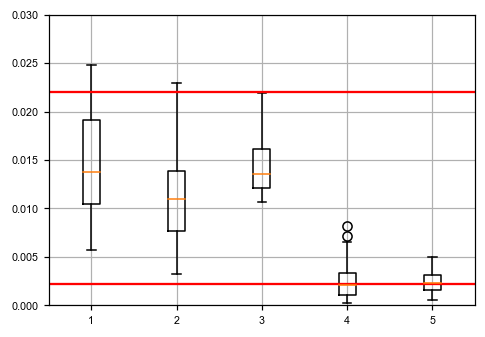

In [91]:
# rCa, rCA, lp = calc_genlik_constant(np.log10(0.05),600,10000,haps)
# plt.figure(dpi=150)
# plt.plot(rCa,color='coral',label=r'$r(C_a)$',ls='--'); plt.plot(rCA,color='olive',ls='-.',label=r'$r(C_A)$'); plt.box(False); [plt.axvline(t,color='k',alpha=0.6,linewidth=0.8) for t in np.unique(np.where([haps[t]!=haps[t-1] for t in range(1,len(haps))])[0])]; plt.xlabel('gens ago'); plt.plot(np.exp(lp),color='goldenrod',label=r'$\ell$'); plt.legend()

# rCa, rCA, lp = calc_genlik_changing(np.log10(0.0001),1000,Nc[:750],haps)
# A = np.array([[ 3. ,  2. , -1. ],
#                [ 2. , -2. ,  4. ],
#                [-1. ,  0.5, -1. ]])
# solve = linalg.factorized(A)
# plt.figure(dpi=150)
# plt.plot(rCa,color='coral',label=r'$r(C_a)$',ls='--'); plt.plot(rCA,color='olive',ls='-.',label=r'$r(C_A)$'); plt.box(False); [plt.axvline(t,color='k',alpha=0.6,linewidth=0.8) for t in np.unique(np.where([haps[t]!=haps[t-1] for t in range(1,len(haps))])[0])]; plt.xlabel('gens ago'); plt.plot(np.exp(lp),color='goldenrod',label=r'$\ell$'); plt.legend()
# plt.boxplot([np.abs(est22clues)[np.where(~np.isnan(est22clues))[0]],np.array(est22)[np.where(~np.isnan(est22))[0]]],widths=0.2); plt.axhline(0.0022,color='red'); 
# plt.boxplot([np.abs(est220clues)[np.where(~np.isnan(est220clues))[0]],np.abs(est220old)[np.where(~np.isnan(est220clues))[0]],np.abs(est)[np.where(~np.isnan(est220clues))[0]],np.abs(est22clues)[np.where(~np.isnan(est22clues))[0]],np.array(est22)[np.where(~np.isnan(est22))[0]]],widths=0.2); plt.axhline(0.022,color='red'); plt.ylim((0,0.03)); plt.grid(); plt.axhline(0.0022,color='red'); #plt.semilogy()
# np.nanmean(np.abs(est)-0.022)
# np.savetxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/resfiles/res22.txt",np.array(est22))
# np.savetxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/resfiles/res220clues.txt",np.array(est220clues))
# est220old = np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/resfiles/res220clues.txt')
# est = np.loadtxt('/Users/vivaswatshastry/selCoefEst/PReFerSims/resfiles/res220.txt')

In [6]:
# haps, _ = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-0.005_Neff_10_t1250.ms',40) 
# 10**sp.optimize.minimize_scalar(foo2, method='bounded', bounds=(-2,-1.5), tol=1e-3).x
# foo = lambda s: calc_genlik_changing(s, 1000, Nc[:750], haps) 
# foo2 = lambda s: -np.nansum(calc_genlik_changing_coal(s, 500, '/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/example_Neff.coal', haps)[2])
# foo2(-1.5)
# finalll = Parallel(n_jobs=16)(delayed(foo2)(x) for x in np.linspace(-3,-2,16))
# plt.plot(10**np.linspace(-3,-2,16),[finalll[i] for i in range(16)],'ko'); plt.grid(); plt.axvline(50/10000,color='r'); plt.ylabel(r'$\ell$'); plt.xlabel(r'$\hat s$'); plt.title(r'$T_{max}=12000, 2n=400$'); #plt.axvline(10**np.linspace(-2,-1.5,16)[2],color='grey')
# haps, _ = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-0.011_Neff_{:d}_t750.ms'.format(5),40) 
# 10**sp.optimize.minimize_scalar(foo2, method='bounded', bounds=(-2.5,-1.5), tol=1e-3)
# len(np.where(np.isnan(est22))[0]+1)

CPU times: user 36.2 ms, sys: 88.9 ms, total: 125 ms
Wall time: 8.68 s


[]

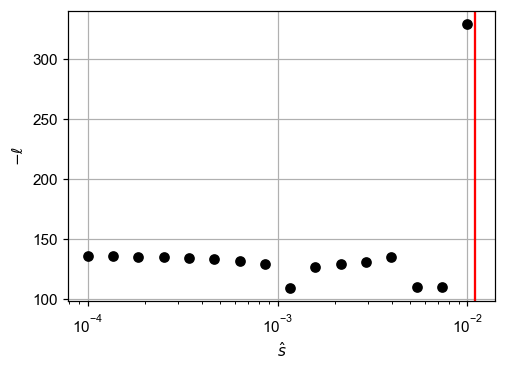

In [39]:
# foo = lambda s: calc_genlik_constant(s, 100, 10000, haps) 
# finalll = Parallel(n_jobs=16)(delayed(foo)(x) for x in np.linspace(-2.5,-1.5,16))
# finalll2 = Parallel(n_jobs=16)(delayed(foo2)(x) for x in np.linspace(-2.5,-1.5,16))
# plt.plot([-np.nansum(finalll2[i][2]) for i in range(16)],[-np.nansum(finalll[i][2]) for i in range(16)],'ko'); plt.axline((100,100),slope=1)
# -np.sum(foo(-3.5)[2])
# plt.imshow(np.log10(run_mom_iterate_constant(601, 600, 10**-1.3, 10000, 400)),vmin=-10,aspect='auto',cmap='Blues'); plt.colorbar()
%time finalll = Parallel(n_jobs=16)(delayed(foo2)(x) for x in np.linspace(-4,-2,16))
plt.plot(10**np.linspace(-4,-2,16),[-np.nansum(finalll[i][2]) for i in range(16)],'ko'); plt.grid(); plt.axvline(110/10000,color='r'); plt.ylabel(r'$-\ell$'); plt.xlabel(r'$\hat s$'); plt.semilogx()#plt.axvline(10**np.linspace(-2,-1.3,12)[2],color='grey')
# sp.optimize.minimize(foo2, x0=-2, method='b', bounds=[(-3.7,-1.7)])
# sp.optimize.minimize_scalar(foo2, method='bounded', bounds=(-3.7,-1.7))
## est = []
# est220 = []
# est005 = []
# for i in range(1,101):
#     try:
#         haps, _ = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-0.005_Neff_{:d}_t1250.ms'.format(i),40) 
#         foo2 = lambda s: -np.nansum(calc_genlik_constant(s, 300, 10000, haps)[2])
#         est005.append(10**sp.optimize.minimize_scalar(foo2, method='bounded', bounds=(-3.5,-1.8), tol=1e-4).x)
#     except:
#         est005.append(np.nan)
#     print(est005[-1])
# for i in np.array([2, 4, 7, 11, 13, 14, 15, 25, 27, 31, 33, 36, 45, 48, 53, 55, 57, 58, 59, 60, 61, 67, 71, 72, 78, 82, 83, 84, 85, 87, 88, 90, 92, 96, 97, 98]):
#     haps = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-220.0_{:d}_t600.ms'.format(i),40) 
#     est[i-1] = 10**sp.optimize.minimize_scalar(foo2, method='bounded', bounds=(-2.1,-1.5), tol=1e-2).x
#     print(est[i-1])

# plt.figure(dpi=150); plt.box(False)
# plt.violinplot([np.array(est22)[np.where(~np.isnan(est22))[0]],np.array(est)[np.where(~np.isnan(est))[0]]],widths=0.01,showmedians=True,positions=[0,.03]); plt.axhline(0.022,color='red'); plt.axhline(0.0022,color='red'); plt.ylim((0,0.03)); plt.ylabel(r'estimated $\hat s$'); plt.axhline(0.022,color='red'); plt.ylim((0,0.03)); plt.xticks([0,.03],labels=[r'0.0022',r'0.022']); plt.xlabel(r'simulated $s$'); 

# plt.figure(dpi=150)
# plt.plot(allfreq[np.where(~np.isnan(est22))[0]][:,-1],np.array(est22)[np.where(~np.isnan(est22))[0]],'o',color='dodgerblue',alpha=0.8,label=r'$0.0022$'); plt.plot(allfreq220[np.where(~np.isnan(est))[0]][:,-1],np.array(est)[np.where(~np.isnan(est))[0]],'*',alpha=0.5,color='dodgerblue',label=r'$0.022$'); plt.grid(); plt.xlabel('present-day freq.'); plt.ylabel(r'$\hat s$'); plt.axhline(0.0022,color='red'); plt.axhline(0.022,color='red'); plt.legend(title=r'$s$');
# plt.figure(dpi=150)
# plt.plot(range(1,100),fsa[:,1:-1].sum(axis=0)/400,'-o',color='orange'); 

In [38]:
haps = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-220.0_{:d}_t600.ms'.format(43),40)[0]
haps
# foo2 = lambda s: -np.nansum(calc_genlik_constant(s[0], 400, 10000, haps)[2])
# 10**sp.optimize.minimize(foo2, x0=-2, method='L-BFGS-B', bounds=[(-2.5,-1.5)]).x
# plt.boxplot(np.array(est011)[~np.isnan(est011)]); plt.axhline(0.011,color='red'); plt.ylim((0,0.05)); 
# est220clues = []
# for i in range(1,51):
#     try:
#         haps, coaltimes = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-220.0_{:d}_t600.ms'.format(i),40)
#         idx = np.max(np.where(np.sort(coaltimes[coaltimes[:,1]==1,0])<600))
#         der = np.sort(coaltimes[coaltimes[:,1]==1,0])[:(idx+2)]
#         anc = np.sort(np.append(coaltimes[coaltimes[:,1]==0,0],np.sort(coaltimes[coaltimes[:,1]==1,0])[(idx+2):]))
#         f = open("/Users/vivaswatshastry/CLUES2/Times2.txt", "w")
#         f.writelines(np.array2string(der,separator=',').replace(" ", "")[1:-1].replace("\n", "") + "\n" + np.array2string(anc,separator=',').replace(" ", "")[1:-1].replace("\n", "") + "\n")
#         f.close()

#         os.system("python /Users/vivaswatshastry/CLUES2/inference.py --times /Users/vivaswatshastry/CLUES2/Times2.txt --N 40000 --out out --tCutoff 600 --popFreq {:.2f} --noAlleleTraj".format(haps[0,0]/haps[0,1]))

#         est220clues.append(np.loadtxt("out_inference.txt", skiprows=1)[-1])
#     except:
#         est220clues.append(np.nan)
#     print(est220clues[-1])

array([[14, 40],
       [14, 40],
       [14, 40],
       ...,
       [ 4, 21],
       [ 4, 21],
       [ 3, 20]], dtype=int16)

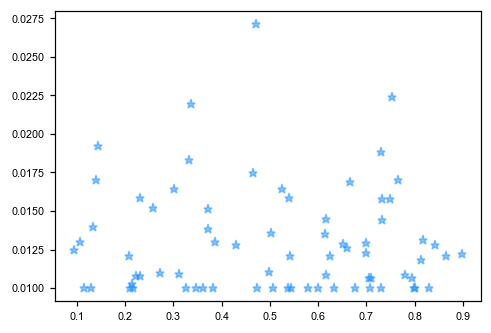

In [96]:
# plt.plot(allfreq220[np.where(~np.isnan(est))[0]][:,-1],np.array(est)[np.where(~np.isnan(est))[0]],'*',alpha=0.5,color='dodgerblue',label=r'$0.022$');

Text(0.5, 1.0, '$\\gamma=100$')

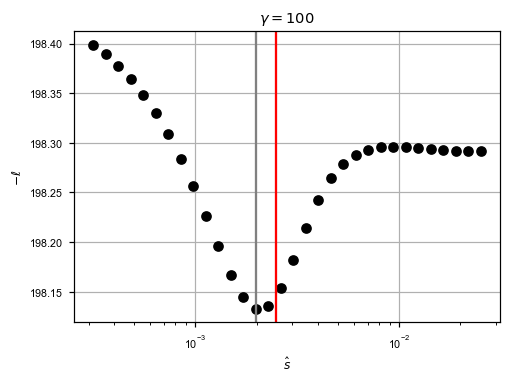

In [ ]:
## standard: haps-100.0_15.ms
# finalll = Parallel(n_jobs=16)(delayed(foo)(x) for x in np.linspace(-3.5,-1.6,32))
# plt.plot(10**np.linspace(-3.5,-1.6,32),finalll,'ko'); plt.grid(); plt.axvline(100/40000,color='r'); plt.ylabel(r'$-\ell$'); plt.xlabel(r'$\hat s$'); plt.axvline(10**np.linspace(-3.5,-1.6,32)[np.nanargmin(finalll)],color='grey'); plt.semilogx(); plt.title(r'$\gamma=100$')

In [ ]:
def calc_neutral_constant(N, haps):
    ## if we used the time between coalescences and computed the log-lik
    coaltimes = np.append(1,[i for i in [t if ~(haps[t,:] == haps[t-1,:]).all() else None for t in range(1,len(haps))] if i is not None])

    logprob = np.zeros(len(coaltimes))

    for it in range(1,len(coaltimes)):
        logprob[it-1] = np.log(np.exp(-(coaltimes[it]-coaltimes[it-1])*0.25*haps[coaltimes[it-1]-1,1]*(haps[coaltimes[it-1]-1,1]-1)/N)) + np.log(0.25*haps[coaltimes[it-1]-1,1]*(haps[coaltimes[it-1]-1,1]-1)/N)

    ## going generation by generation
    logprob2 = np.zeros(len(haps))

    for t in range(1,len(haps)):
        if (haps[t,:] == haps[t-1,:]).all():
            logprob2[t] = np.log(np.exp(-0.25*haps[t-1,1]*(haps[t-1,1]-1)/N)) # ≈ np.exp(-0.5*haps[t-1,0]*(haps[t-1,0]-1)/N)
        else:
            logprob2[t] = np.log(1-np.exp(-haps[t-1,1]*(haps[t-1,1]-1)*0.25/N)) # np.log(0.25*haps[t-1,1]*(haps[t-1,1]-1)/N) 

    return logprob, logprob2[1:]

In [1185]:
# logprob0, logprob02 = calc_neutral_constant(10000, haps)
# np.sum(logprob0), np.sum(logprob02), np.sum(logprob)
# np.sum(logprob02[[i for i in [t if ~(haps[t,:] == haps[t-1,:]).all() else None for t in range(1,len(haps))] if i is not None]]) 
# len(logprob02[np.where(np.exp(logprob02)<0.9)])
# plt.plot(np.exp(logprob02),'ko')


Signature: read_mssel(msfile, nind)
Docstring: <no docstring>
File:      /var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_55344/3596824535.py
Type:      function


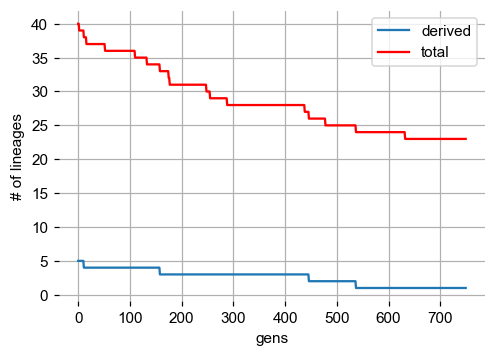

In [42]:
# import os
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims')


# demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/AFRlike_demo.txt", delimiter=" ", dtype='int')
# Nc = []
# [Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
# Nc = np.array(list(it.chain(*Nc))); Nc = Nc[::-1]

# from numpy import sort
# haps, coaltimes = read_mssel('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/hapfiles/haps-0.011_Neff_10_t750.ms',40) 
# plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total', color='red'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend()
# T = 750
# np.sort(coaltimes[coaltimes[:,1]==0,0]), np.sort(coaltimes[coaltimes[:,1]==1,0])
# idx = np.max(np.where(np.sort(coaltimes[coaltimes[:,1]==1,0])<750))
# np.sort(coaltimes[coaltimes[:,1]==1,0])[:(idx+2)], np.sort(np.append(coaltimes[coaltimes[:,1]==0,0],np.sort(coaltimes[coaltimes[:,1]==1,0])[(idx+2):]))

In [1184]:
# der = np.append(np.nan,[i for i in [t if ~(haps[t,0] == haps[t-1,0]).all() else None for t in range(1,len(haps))] if i is not None])[1:]
# tot = np.append(np.nan,[i for i in [t if ~(haps[t,1] == haps[t-1,1]).all() else None for t in range(1,len(haps))] if i is not None])[1:]
# der,np.sort(list(set(tot) - set(der)))

(array([2.000, 47.000, 51.000, 80.000, 101.000, 110.000, 114.000, 216.000,
        250.000]),
 array([1.000, 5.000, 21.000, 22.000, 38.000, 50.000, 64.000, 144.000,
        179.000, 227.000, 301.000, 454.000, 630.000]))

In [535]:
# foo = lambda s: calc_genlik_constant(s, 100, 10000, haps[:320])
# -3: (280, -118.98, -19.05); (320, -122.96, -17.97)
# -np.sum(foo(-3)[2])
# fsa = run_mom_iterate_constant(12000, 100, 0.001, 10000, 400)
# fsa[fsa<0] = 0
# fsT = np.zeros(12000)
# for t in range(1,12000):
#     fsT[t] = moments.Spectrum(fsa[t,:]).project([40])[11]
# plt.plot(fsT[::-1]/fsT.sum())
np.log(fsT[-500:-250].sum()/fsT.sum()), fsT[-800:-280].sum()/fsT.sum()

(-12.28603624992352, 0.00018186657721102513)

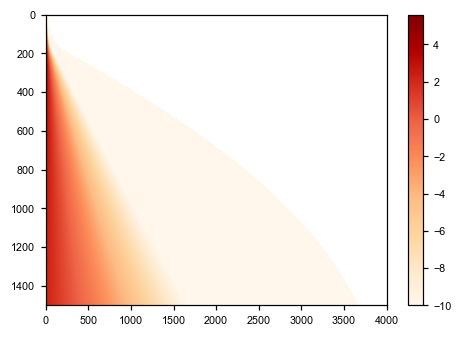

In [441]:
# fsa = run_mom_iterate_constant(10000, 120, 0.01, 10000, 400)
# fsa = run_mom_iterate_changing4(4000, 0.01, Nc[:1500], 400)
# fsa[fsa<0] = 0
# plt.imshow(np.log10(fsa),vmin=-10,aspect='auto',cmap='OrRd'); plt.colorbar()
# plt.plot(moments.Spectrum(fsa[10,]).project([40]),'o'); plt.plot(moments.Spectrum(fsa[100,]).project([40]),'o'); plt.plot(moments.Spectrum(fsa[400,]).project([40]),'o'); plt.semilogy(); 
# fsprojn = moments.Spectrum(fsa[200,:]).project([10])
# fsprojn[1:-1] = fsprojn[1:-1]/fsprojn[1:-1].sum()
# plt.plot(np.log10(fsa.sum(axis=0)),'-o')
# np.where(np.array(res100)>0.01)[0], np.where(np.isnan(res100))

In [952]:
fsprojn[3]

0.006957716326835276

In [ ]:
# fsa = run_mom_iterate_constant(T, 3, s, N, 100, {})
# fs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(400,gamma=-25))*400
# fs = fs/fs.sum()
# plt.plot(fs.project([2]))
# fs.project([3])/fs.project([3]).sum() #[-- 0.9726728471678365 0.026575356182170495 0.0007517966499929211 --]
# fsap = (fsa.T/fsa.sum(axis=1)).T

### Computing the MLE $\hat s$ values for each simulated trajectory in PReFerSim -> bioinfo -> mssel -> ipynb

In [ ]:
# dft = pd.read_csv('outfiles/ConstantSize-50.0.1.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.drop(np.where(dft['sXl']==200)[0])
# dft['res'] = np.zeros(dft.shape[0])
# plt.boxplot(dft['res']); plt.semilogy(); plt.axhline(0.025,color='red'); plt.xlabel(r'$\hat s$'); 
# plt.plot(dft['al'],dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.xlabel('allele age'); plt.ylabel(r'$\hat s$')
# plt.plot(dft['sXl']*0.2,dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.xlabel('sample freq.'); plt.ylabel(r'$\hat s$')
# plt.plot(dft['sXl']/dft['al'],dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.ylabel(r'$\hat s$'); plt.axhline(0.025,color='red'); plt.xlabel(r'$i/a$')
# plt.boxplot(dft['res'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))]); plt.axhline(0.025, color='red'); plt.xlabel(r'$\hat s$'); plt.semilogy(); plt.ylim((1e-3,1e-1))
# plt.scatter(dft['al'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))],dft['sXl'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))]*0.2); plt.xlabel('allele age'); plt.ylabel('sample freq.'); plt.grid()

In [ ]:
# os.system("sed -n '/^{}/p' MiniTest/Traj-500.0.txt > MiniTest/TrajMini-500.0.txt".format(dft['al'].iloc[i]))
# np.where(((dft['sXl']>3) & (dft['sXl']<150)))[0]
# i = 40
# os.system("sed -n '/^{}/p' MiniTest/Traj-50.0.txt > MiniTest/TrajMini-50.0.txt".format(dft['id'].iloc[i]))
# os.system("perl TrajToMsselFormat.pl MiniTest/TrajMini-50.0 20000 msselfiles/trajfiles/TrajMsselLike-50.0.txt 1 0 1")
# os.system("cat msselfiles/trajfiles/TrajMsselLike-50.0.txt | ~/mssel/stepftn > msselfiles/trajfiles/CurrTraj-50.0.txt")
# os.system("~/mssel/mssel3 50 1 {} {} msselfiles/trajfiles/CurrTraj-50.0.txt 500 -r 0 1000 -t 20 -T > msselfiles/haps-50.0.ms".format(int(np.floor((200-dft['sXl'].iloc[i]) * 0.25)),int(np.ceil(dft['sXl'].iloc[i] * 0.25))))
# print(dft['sXl'].iloc[i], dft['al'].iloc[i])

# res = [0.00016259837958348586]
res25 = []

for rep in range(1,26):
    try:
        haps = read_mssel('msselfiles/haps-25.0_{}.ms'.format(rep),40)
        foo = lambda s: calc_genlik(s, 500, 10000, haps)
        res25.append(10**sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-5,-2), options={'xatol':1e-3}).x)
        print(res25[rep-1])
    except:
        res25.append(np.nan)
# plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=100$')

In [ ]:
# int(np.floor((200-dft['sXl'].iloc[i]) * 0.5)),int(np.ceil(dft['sXl'].iloc[i] * 0.5))
# plt.hist(res[1:])
# plt.boxplot(np.array(res)[~np.isnan(res).astype(int)]); plt.axhline(0.01,color='red'); plt.ylim((0.0001,0.1)); plt.semilogy()

In [ ]:
## bioinformatics to run mssel
# for i in range(56,len(dft)):
#     os.system("sed -n '/^{}/p' MiniTest/Traj-50.0.txt > MiniTest/TrajMini-50.0.txt".format(dft['id'].iloc[i]))
#     os.system("perl TrajToMsselFormat.pl MiniTest/TrajMini-50.0 20000 msselfiles/trajfiles/TrajMsselLike-50.0.txt 1 0 1")
#     os.system("cat msselfiles/trajfiles/TrajMsselLike-50.0.txt | ~/mssel/stepftn > msselfiles/trajfiles/CurrTraj-50.0.txt")
#     os.system("~/mssel/mssel3 40 1 {} {} msselfiles/trajfiles/CurrTraj-50.0.txt 500 -r 0 1000 -t 20 -T > msselfiles/haps-50.0.ms".format(int(np.floor((200-dft['sXl'].iloc[i]) * 0.2)),int(np.ceil(dft['sXl'].iloc[i] * 0.2))))

#     try: 
#         haps = read_mssel('msselfiles/haps-50.0.ms',40)
#     except:
#         dft['res'].iloc[i] = np.nan
#         continue
#     # plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=50$')

#     foo = lambda s: calc_genlik(s, 500, 10000, haps)
#     dft['res'].iloc[i] = 10**sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-5,-2), options={'xatol':1e-3}).x
#     print(i, dft['sXl'].iloc[i], dft['al'].iloc[i], dft['res'].iloc[i])
#     # print(10**res.x)

In [ ]:
res